In [1]:
# === CELL 1: TẢI DỮ LIỆU & CHUẨN BỊ (ĐÃ SỬA LỖI XÓA URL) ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Import các mô hình
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Import các công cụ đánh giá
from sklearn.metrics import classification_report, accuracy_score

# 1. Tải dữ liệu
FINAL_FEATURES_PATH = '../data/processed/dataset_final_features.csv'
df = pd.read_csv(FINAL_FEATURES_PATH)

print(f"Kích thước dữ liệu gốc: {df.shape}")

# 2. XÓA CỘT KHÔNG PHẢI SỐ (QUAN TRỌNG NHẤT)
# Xóa cột 'url' (chuỗi) và 'label' (đích)
# errors='ignore' giúp code không lỗi nếu bạn lỡ chạy 2 lần
X = df.drop(columns=['url', 'label'], axis=1, errors='ignore')
y = df['label']

# --- BƯỚC AN TOÀN: Kiểm tra và xóa bất kỳ cột nào còn sót lại dạng chữ ---
non_numeric_cols = X.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    print(f"⚠️ CẢNH BÁO: Phát hiện các cột dạng chữ còn sót lại: {non_numeric_cols.tolist()}")
    print("Đang tự động xóa các cột này...")
    X = X.drop(columns=non_numeric_cols, axis=1)

print("\nDanh sách các cột đặc trưng cuối cùng (X):")
print(X.columns.tolist())

# 3. Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\n✅ Dữ liệu đã sẵn sàng để huấn luyện (chỉ còn số)!")
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Kích thước dữ liệu gốc: (507195, 23)
⚠️ CẢNH BÁO: Phát hiện các cột dạng chữ còn sót lại: ['ensure_scheme']
Đang tự động xóa các cột này...

Danh sách các cột đặc trưng cuối cùng (X):
['get_url_length', 'get_hostname_length', 'count_dots', 'count_hyphens', 'count_at_symbol', 'count_slashes', 'count_question_mark', 'count_equals', 'count_and_symbol', 'get_path_length', 'count_digits_in_url', 'count_letters_in_url', 'count_digits_in_hostname', 'has_https', 'has_suspicious_tld', 'count_sensitive_words', 'has_ip_address_in_hostname', 'get_subdomain_count', 'get_domain_age_days', 'get_domain_lifespan_days']

✅ Dữ liệu đã sẵn sàng để huấn luyện (chỉ còn số)!
Train shape: (405756, 20)
Test shape: (101439, 20)


In [2]:
# Tạo một từ điển chứa các mô hình bạn muốn so sánh
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
}

# Tạo một DataFrame để lưu kết quả
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Phishing Precision', 'Phishing Recall', 'Phishing F1-Score', 'Training Time (s)'])

for name, model in models.items():
    print(f"--- Bắt đầu huấn luyện: {name} ---")
    
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    
    training_time = end_time - start_time
    
    print(f"--- Bắt đầu đánh giá: {name} ---")
    y_pred = model.predict(X_test)
    
    # Lấy các chỉ số từ classification_report
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = report['accuracy']
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1_score = report['1']['f1-score']
    
    # Thêm kết quả vào DataFrame
    results.loc[len(results)] = [name, accuracy, precision, recall, f1_score, training_time]
    
    print(f"Hoàn thành {name} trong {training_time:.2f} giây.\n")

--- Bắt đầu huấn luyện: Logistic Regression ---
--- Bắt đầu đánh giá: Logistic Regression ---
Hoàn thành Logistic Regression trong 21.32 giây.

--- Bắt đầu huấn luyện: Random Forest ---
--- Bắt đầu đánh giá: Random Forest ---
Hoàn thành Random Forest trong 57.99 giây.

--- Bắt đầu huấn luyện: XGBoost ---


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:30:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Bắt đầu đánh giá: XGBoost ---
Hoàn thành XGBoost trong 3.47 giây.



Bảng so sánh hiệu suất các mô hình:


,Model,Accuracy,Phishing Precision,Phishing Recall,Phishing F1-Score,Training Time (s)
1,Random Forest,0.925256,0.870861,0.784689,0.825533,57.986670
2,XGBoost,0.917103,0.879670,0.732327,0.799265,3.465097
0,Logistic Regression,0.854267,0.823520,0.449694,0.581728,21.319066


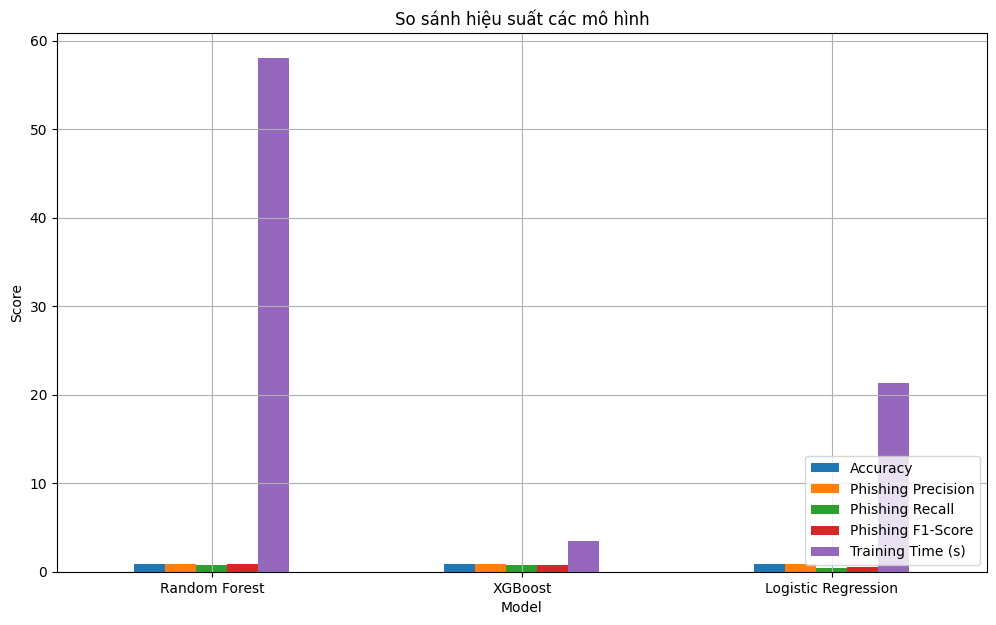

In [3]:
# Sắp xếp kết quả theo F1-score
results.sort_values(by='Phishing F1-Score', ascending=False, inplace=True)

print("Bảng so sánh hiệu suất các mô hình:")
display(results)

# Trực quan hóa
results.set_index('Model').plot(kind='bar', figsize=(12, 7), grid=True)
plt.title("So sánh hiệu suất các mô hình")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

In [4]:
from sklearn.model_selection import RandomizedSearchCV

print("--- Bắt đầu tinh chỉnh tham số cho XGBoost ---")

# Định nghĩa không gian tham số để tìm kiếm
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Khởi tạo RandomizedSearchCV
# n_iter: số lượng kết hợp tham số sẽ thử
# cv: số fold của cross-validation
xgb_tuned = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
    param_distributions=param_grid,
    n_iter=15, # Thử 15 kết hợp ngẫu nhiên
    cv=3,
    verbose=2, # Hiển thị tiến trình
    random_state=42,
    scoring='f1' # Tối ưu theo F1-score của lớp dương
)

# Bắt đầu quá trình tìm kiếm
start_time = time.time()
xgb_tuned.fit(X_train, y_train)
end_time = time.time()

print(f"\nHoàn thành tinh chỉnh trong {(end_time - start_time)/60:.2f} phút.")
print(f"Các tham số tốt nhất tìm được: {xgb_tuned.best_params_}")

--- Bắt đầu tinh chỉnh tham số cho XGBoost ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:30:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.7; total time=  10.5s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:30:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.7; total time=   9.7s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:30:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.7; total time=  10.0s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:30:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   2.1s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:30:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   2.4s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:30:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   3.0s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:30:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9; total time=   5.6s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:31:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9; total time=   5.1s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:31:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9; total time=   5.5s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:31:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   2.8s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:31:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   3.3s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:31:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   2.9s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:31:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   2.1s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:31:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   2.5s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:31:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   2.3s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:31:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   3.7s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:31:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   3.3s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:31:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   3.4s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:31:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   4.2s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:31:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   3.9s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:31:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   4.1s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:31:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8; total time=   7.4s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:32:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8; total time=   7.7s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:32:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8; total time=   7.7s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:32:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.9; total time=   5.9s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:32:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.9; total time=   5.7s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:32:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.9; total time=   5.9s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:32:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   2.2s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:32:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   2.2s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:32:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   2.1s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:32:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=10, n_estimators=300, subsample=0.9; total time=  12.8s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:32:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=10, n_estimators=300, subsample=0.9; total time=  13.0s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:33:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=10, n_estimators=300, subsample=0.9; total time=  12.5s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:33:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.9; total time=   3.4s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:33:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.9; total time=   3.3s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:33:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.9; total time=   3.5s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:33:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   3.3s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:33:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   3.1s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:33:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   2.8s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:33:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   8.1s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:33:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   7.4s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:33:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   7.3s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:34:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.7; total time=   6.3s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:34:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.7; total time=   5.8s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:34:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.7; total time=   5.6s


c:\Users\ASUS\Documents\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:34:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Hoàn thành tinh chỉnh trong 4.35 phút.
Các tham số tốt nhất tìm được: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}



--- Báo cáo Phân loại cho Mô hình XGBoost Tốt nhất ---
              precision    recall  f1-score   support

  Legitimate       0.93      0.97      0.95     78579
    Phishing       0.89      0.76      0.82     22860

    accuracy                           0.92    101439
   macro avg       0.91      0.86      0.88    101439
weighted avg       0.92      0.92      0.92    101439



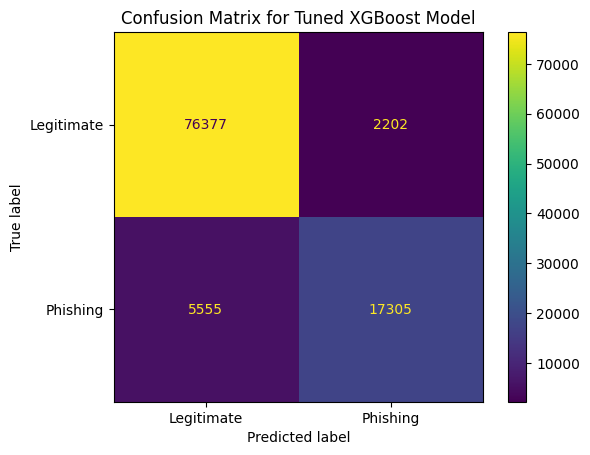

In [5]:
# === CELL 5: ĐÁNH GIÁ MÔ HÌNH TỐT NHẤT (ĐÃ SỬA LỖI IMPORT) ===

# 1. Thêm dòng import này để sửa lỗi
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# 2. Lấy ra mô hình tốt nhất
best_xgb = xgb_tuned.best_estimator_

# 3. Dự đoán trên tập test
y_pred_best = best_xgb.predict(X_test)

# 4. In báo cáo
print("\n--- Báo cáo Phân loại cho Mô hình XGBoost Tốt nhất ---")
print(classification_report(y_test, y_pred_best, target_names=['Legitimate', 'Phishing']))

# 5. Vẽ ma trận nhầm lẫn
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, display_labels=['Legitimate', 'Phishing'])
plt.title("Confusion Matrix for Tuned XGBoost Model")
plt.show()

In [ ]:
# === CELL CUỐI CÙNG: TEST THỬ URL (PHIÊN BẢN FINAL FIX DTYPE) ===

import sys
import os
import pandas as pd
import numpy as np 

# Đảm bảo đường dẫn đúng
sys.path.append(os.path.abspath('..'))

from src.features import lexical_features
from src.features import host_features

def get_feature_functions_strict(module):
    functions = {}
    for name, func in module.__dict__.items():
        if callable(func) and not name.startswith("__") and func.__module__ == module.__name__:
            functions[name] = func
    return functions

def predict_url(model, url: str, training_columns: list):
    print(f"🔎 Đang phân tích URL: {url}")
    
    # --- 1. TRÍCH XUẤT ĐẶC TRƯNG ---
    url_features = {}

    lexical_funcs = get_feature_functions_strict(lexical_features)
    for name, func in lexical_funcs.items():
        try:
            url_features[name] = func(url)
        except:
            url_features[name] = 0

    host_funcs = get_feature_functions_strict(host_features)
    for name, func in host_funcs.items():
        try:
            url_features[name] = func(url)
        except:
            url_features[name] = -1

    # --- 2. TẠO DATAFRAME & ĐỒNG BỘ CỘT ---
    url_df = pd.DataFrame([url_features])
    
    # Tạo khung dữ liệu chuẩn với các cột training
    final_df = pd.DataFrame(columns=training_columns)
    
    # Gán dữ liệu vào
    for col in training_columns:
        if col in url_df.columns:
            final_df.loc[0, col] = url_df.iloc[0][col]
        else:
            final_df.loc[0, col] = 0
            
    # Sắp xếp đúng thứ tự
    final_df = final_df[training_columns]
    
    # === [QUAN TRỌNG] FIX LỖI DTYPE Ở ĐÂY ===
    # Ép toàn bộ dữ liệu về dạng số thực (float) để XGBoost hiểu
    final_df = final_df.astype(float)
    # ========================================
    
    # --- DEBUG ---
    print("[DEBUG] Các đặc trưng quan trọng:")
    cols_to_show = ['get_url_length', 'count_digits_in_url', 'count_dots', 'has_ip_address_in_hostname']
    for col in cols_to_show:
        if col in final_df.columns:
            val = final_df.iloc[0][col]
            print(f"  - {col}: {val} (Type: {type(val)})")
    
    # --- 3. DỰ ĐOÁN ---
    try:
        prediction = model.predict(final_df)[0]
        probabilities = model.predict_proba(final_df)[0]
        
        print("\n--- KẾT QUẢ ---")
        if prediction == 1:
            print(f"🚨 PHISHING (Lừa đảo) - Độ tin cậy: {probabilities[1]*100:.2f}%")
        else:
            print(f"✅ LEGITIMATE (Hợp lệ) - Độ tin cậy: {probabilities[0]*100:.2f}%")
    except Exception as e:
        print(f"Lỗi khi dự đoán: {e}")
        # In thêm chi tiết lỗi nếu cần
        import traceback
        traceback.print_exc()

# --- CHẠY TEST ---
try:
    # Đảm bảo dùng mô hình tốt nhất và danh sách cột tương ứng
    # Nếu best_xgb là pipeline, nó có thể tự xử lý, nhưng nếu là model trần thì cần ép kiểu
    model_to_use = best_xgb 
    cols_to_use = X_train.columns
    
    print("="*40)
    predict_url(model_to_use, "https://chatgpt.com/c/69217e50-64f4-8328-8d65-3e6a14352a2b", cols_to_use)
    
    print("\n" + "="*40)
    predict_url(model_to_use, "http://facebook.verify-login-id123.example", cols_to_use)

except NameError:
    print("Lỗi: Biến model hoặc X_train không tồn tại.")

🔎 Đang phân tích URL: https://chatgpt.com/c/69217e50-64f4-8328-8d65-3e6a14352a2b
[DEBUG] Các đặc trưng quan trọng:
  - get_url_length: 58.0 (Type: <class 'numpy.float64'>)
  - count_digits_in_url: 25.0 (Type: <class 'numpy.float64'>)
  - count_dots: 1.0 (Type: <class 'numpy.float64'>)
  - has_ip_address_in_hostname: 0.0 (Type: <class 'numpy.float64'>)

--- KẾT QUẢ ---
✅ LEGITIMATE (Hợp lệ) - Độ tin cậy: 92.46%

🔎 Đang phân tích URL: http://facebook.verify-login-id123.example
[DEBUG] Các đặc trưng quan trọng:
  - get_url_length: 42.0 (Type: <class 'numpy.float64'>)
  - count_digits_in_url: 3.0 (Type: <class 'numpy.float64'>)
  - count_dots: 2.0 (Type: <class 'numpy.float64'>)
  - has_ip_address_in_hostname: 0.0 (Type: <class 'numpy.float64'>)

--- KẾT QUẢ ---
🚨 PHISHING (Lừa đảo) - Độ tin cậy: 99.81%
